In [32]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *

#Interactive graph modules
# %matplotlib notebook
from ipywidgets import *

In [33]:
#Configure simulation paratmers
#Geometric Parameters
r_max = 3 # maximum radial distance of simulation (m)
n = 2000 #surface discretisation
g = 9.81 # gravitational constant

#Time parameters
t_count = 5000*10 #number of timesteps
update_freq = t_count/10
t_max = 10
t = np.linspace(0, t_max, t_count) #time vector


In [34]:
#Set exhast gas parameters (fuel mixture estimate)
R = 8.314/0.028 #[J/mol·K] universal gas constant, normalized by molar mass
gamma = 1.4 # heat capacity ratio
mu_c = 17.49E-6 #[Pa.s] #viscosity in the rocket chamber

In [35]:
#Configure the surface geology parameters
D = (109) *1e-6 #diameter of dust particles (microns)
c = 0.6 #packing concentration in dust layer
sigma = 2500 #[kg/m3]density of dust particle

A_coh = 0 #cohesional shear stress (experimental)
tau_coh = 0 #cohesional shear stress (experimental)
alpha = (20)*np.pi/180 #static angle of repose of cohensionless particles (deg)
alpha_collapse = (25)*np.pi/180 #angle of repose at which avalanche start (deg)

K = 1 # shear stress augmentation factor

In [36]:
#Set rocket engine parameters
r_e = 0.005 #[m] nozzle radius exit
M_e = 5 #nozzle exit mach number
p_c = (1.25E6) #[Pa] rocket chamber pressure (max pressure)
T_c = 300 #[K] #temperature in the rocket chamber
h = 0.2 #[m] nozzle height above surface

In [37]:
#Initialize arrays for data storage
dr = 0.005 # distance between each discretised point (m)
r_max = 8 # upper distance of simulation (m)
r_min = -3 # lower distance of simulation (m)
n = int(abs(r_max-r_min)/dr) #surface discretisation
r = np.linspace(r_min, r_max, n) # simulation x-axis
del_r = 5 / t_count # total movement of 50 D

y = np.zeros(shape=(n, len(t))) #surface elevation vector
dy_dt = np.zeros(shape=(n, len(t))) #mass flow rate vector
tau = np.zeros(shape=(n, len(t))) #surface shear

#p_g = np.zeros(shape=(n, 1)) #initial group pressure

In [38]:
def moving_average(array_var, n_pt=3):
    ret = np.cumsum(array_var, dtype=float)
    ret[n_pt:] = ret[n_pt:] - ret[:-n_pt]
    return ret[n_pt - 1:] / n_pt

In [39]:
def simulate(r):    
    #Loop through simulation time
    for i in range(1, len(t)):
        r = r - del_r*np.ones(n)
        theta = np.arctan(r/h)
        beta = np.arctan(np.diff(np.transpose(y[:,i-1]))/dr)
        beta = np.insert(beta, 0, 0)    
        #Calculate derived values
        k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
        p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
        p_s = np.minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
        p = p_s*np.cos(theta)**(k+4)*np.cos(beta)**2*(1-np.tan(theta)*np.tan(beta))**2 #ground pressure
        u = np.sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
        q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
        rho = 2*q/(np.square(u)) #density
        mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

        #Reynolds Numbers
        Re_D = rho*u*D/mu #particle Reynold number
        Re_theta = rho*u*r/mu #surface Reynold number

        #Fluid Coefficents
        C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
        C_f = 0.84 #friction coefficient of surface

        #Calculated derived values continued
        tau[:,i] = K*C_f*q #surface shear
        tau_star = sigma*c*D*g*(np.cos(beta)*np.tan(alpha) - np.sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
        Xi = 18*mu_c*h/(sigma*D**2*np.sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*np.sqrt(2)*mu_c*np.sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
        a = 1/(0.5 + np.sqrt( 0.25 + (1/Xi) )) #momentum factor

        #Calculate erosion rate
        dy_dt[:,i] = 2*(tau[:,i]-tau_star)/(a*u*sigma*c*np.cos(beta)) # erosion rate
        dy_dt[:,i] = np.nan_to_num(dy_dt[:,i])

        #Apply errosion
        y[:,i] = y[:,i-1]-dy_dt[:,i]*(t[i]-t[i-1]) #surface modification due to erosion, forward euler scheme
        y[0,i] = y[1,i] #correcting for zero erosion at centerline.

        if True:
            y_minslope = y[:,i]
            beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
            beta_minslope = np.insert(beta, 0, 0)
            while max(abs(beta_minslope)) > alpha_collapse:
                for k in range(len(y_minslope)-1):
                    local_slope = np.arctan((y_minslope[k+1]-y_minslope[k])/dr)
                    if abs(local_slope)>alpha_collapse:
                        mid_point = (y_minslope[k+1] + y_minslope[k])/2
                        y_minslope[k] = mid_point - np.sign(local_slope)*alpha*(0.5*dr)
                        y_minslope[k+1] = mid_point + np.sign(local_slope)*alpha*(0.5*dr)
                beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
                beta_minslope = np.insert(beta_minslope, 0, 0)
            y[:,i] = y_minslope
        else:
            #Simple 3-point filtering
            y_filt = moving_average(np.concatenate((np.flip(y[:,i]), y[:,i])))
            y[:,i] = np.flip(y_filt[0:n])

        #Print time update
        if (i%update_freq ==0):
            print(str(i)+' of '+str(len(t)))
    
    #Return the erosion history
    return y

In [40]:
y = np.zeros(shape=(n, len(t))) #surface elevation vector
y_sim = simulate(r)

5000 of 50000
10000 of 50000
15000 of 50000
20000 of 50000
25000 of 50000
30000 of 50000
35000 of 50000
40000 of 50000
45000 of 50000


In [41]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.animation as ani

mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\ishaa\Downloads\ffmpeg-master-latest-win64-gpl-shared\ffmpeg-master-latest-win64-gpl-shared\bin\ffmpeg.exe"

In [42]:
lander_x = [-5]
for i in range(len(t)-1):
    if i <= int(len(t)/2):
        lander_x.append(lander_x[i] + 0.01)
    else:
        lander_x.append(lander_x[i])

C:\Users\ishaa\AppData\Local\Temp\ipykernel_32228\1720557185.py:14: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lander.set_data(lander_x[frame], 0.1)


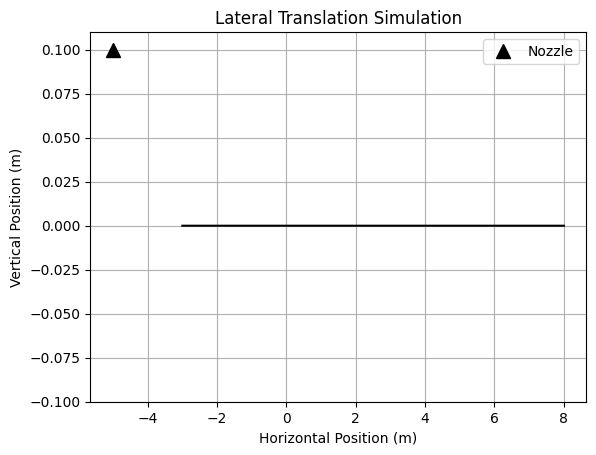

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xlim(-25,25)
ax.set_ylim(-0.1,0.11)
ax.set_xlabel("Horizontal Position (m)")
ax.set_ylabel("Vertical Position (m)")
plt.title("Lateral Translation Simulation")
plt.grid()

line, = ax.plot(r, y_sim[:,0], "k")
lander, = ax.plot(lander_x[0], 0.1, "k^", markersize=10, label="Nozzle")
def update(frame):
    line.set_data(r, y_sim[:,frame])
    lander.set_data(lander_x[frame], 0.1)
    return line, lander,

# Create the animation
animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
plt.legend()
plt.show()
f = r"Animations/crater-lateral3.mp4" 
writervideo = ani.FFMpegWriter(fps=50) 
# animation.save(f, writer=writervideo)

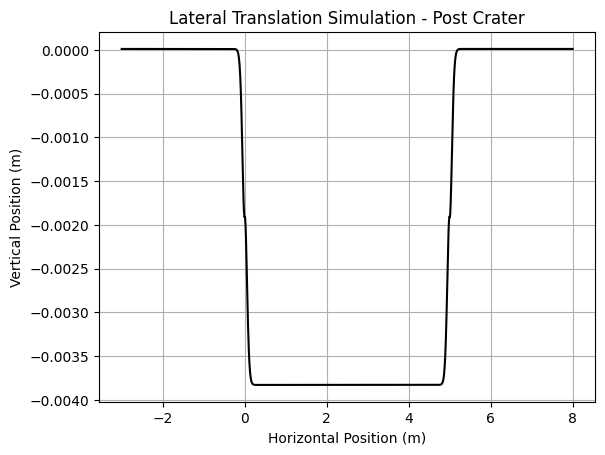

In [44]:
plt.figure()
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("Lateral Translation Simulation - Post Crater")
plt.grid()
plt.plot(r, y_sim[:,-1],"k")